In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
sb.set()

In [2]:
data = pd.read_csv("ground_anomaly.csv")
data.sample(5)

,Unnamed: 0,TIMESTAMP,Pyra1_Wm2_Avg,Pyra2_Wm2_Avg,RECORD,AmbTemp_C_Avg,InvPAC_kW_Avg,InvPDC_kW_Avg,PwrMtrP_kW_Avg
492718,492718,2017-12-09 01:35:00-05:00,-7.959892,-3.082096,706763.0,1.867,0.0000,0.00000,0.00000
145310,145310,2017-04-11 23:02:00-05:00,-6.653044,-2.297562,361663.0,22.870,0.0000,0.00000,0.00000
295607,295607,2017-07-25 10:05:00-05:00,509.670663,512.244335,511443.0,23.180,119.1000,131.00000,117.50000
320644,320644,2017-08-11 18:02:00-05:00,-2.376087,3.082096,536383.0,23.980,0.2825,5.70125,0.02250
226172,226172,2017-06-07 04:47:00-05:00,-3.445326,2.185486,442600.0,15.200,0.0425,0.32125,-0.14125


In [3]:
data = data.drop(['Unnamed: 0', 'RECORD'], axis=1)
data['TIMESTAMP'] = data['TIMESTAMP'].map(lambda x: str(x)[:-6])
data = data.fillna(0)
data.isnull().sum()

TIMESTAMP         0
Pyra1_Wm2_Avg     0
Pyra2_Wm2_Avg     0
AmbTemp_C_Avg     0
InvPAC_kW_Avg     0
InvPDC_kW_Avg     0
PwrMtrP_kW_Avg    0
dtype: int64

In [4]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data = data.set_index('TIMESTAMP')
data.head()

,Pyra1_Wm2_Avg,Pyra2_Wm2_Avg,AmbTemp_C_Avg,InvPAC_kW_Avg,InvPDC_kW_Avg,PwrMtrP_kW_Avg
TIMESTAMP,,,,,,
2017-01-01 00:01:00,-7.959892,-2.633791,6.804,0.0,0.0,0.0
2017-01-01 00:01:00,-7.959892,-2.633791,6.804,0.0,0.0,0.0
2017-01-01 00:03:00,-7.959892,-2.633791,6.792,0.0,0.0,0.0
2017-01-01 00:05:00,-7.959892,-2.633791,6.745,0.0,0.0,0.0
2017-01-01 00:05:00,-7.959892,-2.633791,6.745,0.0,0.0,0.0


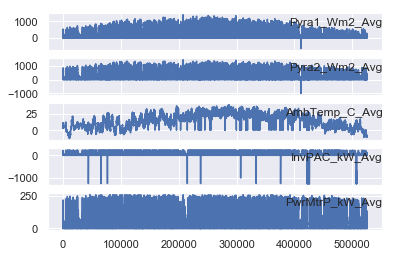

In [5]:
values = data.values
# specify columns to plot
groups = [0, 1, 2, 3, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [6]:
from sklearn import preprocessing

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var5(t)  \
1   0.308284   0.410538   0.379795   0.828716     0.0006    0.00312   0.0006   
2   0.308284   0.410538   0.379795   0.828716     0.0006    0.00312   0.0006   
3   0.308284   0.410538   0.379563   0.828716     0.0006    0.00312   0.0006   
4   0.308284   0.410538   0.378653   0.828716     0.0006    0.00312   0.0006   
5   0.308284   0.410538   0.378653   0.828716     0.0006    0.00312   0.0006   

   var6(t)  
1  0.00312  
2  0.00312  
3  0.00312  
4  0.00312  
5  0.00312  


In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-3], train[:, -2]
test_X, test_y = test[:, :-3], test[:, -2]

In [11]:
print(test_y)

[0.00059955 0.00059955 0.00059955 ... 0.00059955 0.00059955 0.00059955]


In [12]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 5) (8760,) (516839, 1, 5) (516839,)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

data_dim = 3
timesteps = 1

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, data_dim)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Using TensorFlow backend.


ValueError: Error when checking input: expected lstm_1_input to have shape (1, 3) but got array with shape (1, 5)

In [65]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = pd.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: cannot reshape array of size 3101034 into shape (516839,1,1)